> Compare covariances from Morlet Wavelets versus broadband methods for spatial whitening

In this tutorial we will load the fmailiar MNE sample data and compute Morlet wavelets based on [@bomatter2024].
We then compare the covariances and show how to achieve comparable results for spatial whitening with evoked responses.

In [ ]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import mne
from mne.datasets import sample

import pyriemann

from meeglet import compute_spectral_features, spectrum_from_features

In [ ]:
 #| hide
mne.viz.set_browser_backend('matplotlib')
mne.utils.set_log_level('critical')
%load_ext autoreload
%autoreload 2

Using matplotlib as 2D backend.


## Load data 

Let's read in the raw data and pick the EEG channel type

In [ ]:
data_path = sample.data_path()

raw_fname = data_path / 'MEG/sample/sample_audvis_raw.fif'
raw = mne.io.read_raw_fif(raw_fname)
raw = raw.pick_types(meg=False, eeg=True, eog=True, ecg=False, stim=True,
                     exclude=raw.info['bads']).load_data()
raw.set_eeg_reference(projection=True).apply_proj()
raw.resample(200)
raw.filter(1, 32)

Measurement date,"December 03, 2002 19:01:10 GMT"
Experimenter,MEG
Participant,Unknown
Digitized points,146 points
Good channels,"9 Stimulus, 59 EEG, 1 EOG"
Bad channels,None
EOG channels,EOG 061
ECG channels,Not available
Sampling frequency,200.00 Hz
Highpass,1.00 Hz
Lowpass,32.00 Hz


## Basic Steps

### Calssical time-domain covariance computation

The most common way to compute the EEG covariance is the time-domain approach: $$\frac{1}{T} X^\mathsf{T}X,$$ where $X \in \mathbb{R}^{E \times T}$, _i.e._, the EEG signals at $E$ electrodes and $T$ time points. 

For denoising, one usually uses the broad-band covariance. For decoding, it is common to apply band-pass filtering before computing the covariance


In [ ]:
noise_cov = mne.compute_raw_covariance(raw, method='oas')  # broad band
alpha_cov = mne.compute_raw_covariance(raw.copy().filter(8, 12), method='oas') # alpha band

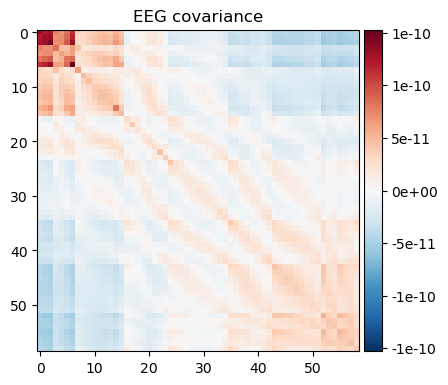

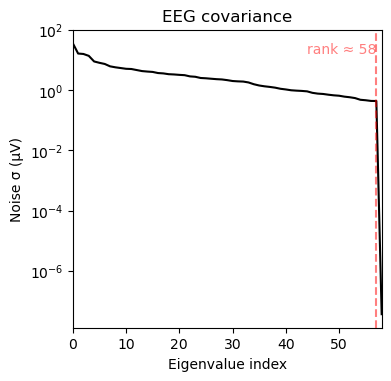

In [ ]:
noise_cov.plot(raw.info);

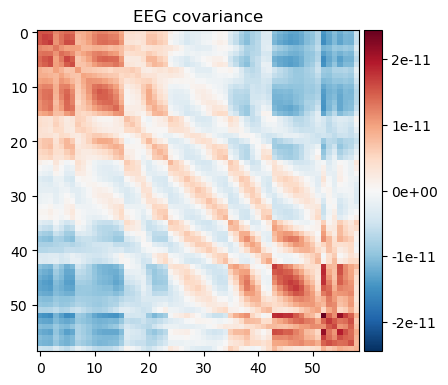

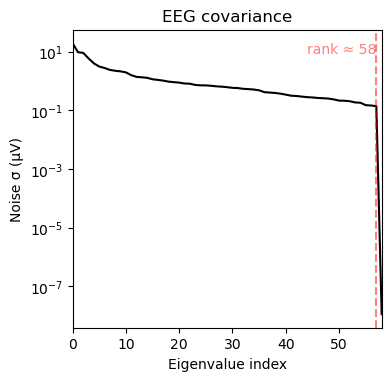

In [ ]:
alpha_cov.plot(raw.info);

We can see that a) the broad band contains larger variance and b) that a few channels in the upper left corner dominate the covariance in the broad-band case. The alpha band covariance is more likely to contain brain signal.



### Compute covariances per frequncy using Morlet wavelets

We can obtain covariances from Morlet Wavelets at eeach freuqency specified as follows.
Let's assume that $\mathsf{Z}^f \in \mathbb{C}^{E \times T}$ is the complex-valued convolved signal at frequency $f$, then its covariance can be denoted as 

$$\text{Re}(\mathsf{Z}^{fH}\mathsf{Z}^f) / \mathrm{n},$$ 

where $^H$ is the conjugate transpose, $\text{Re}$ is the real part, which is divided by the number of (valid) windows used for numerical approximations (not marked for artifact rejection / exclusion).

For details, see [@bomatter2024].


In [ ]:
out, info = compute_spectral_features(
    raw, foi_start=1, foi_end=32, bw_oct=0.25, delta_oct=1,
    density='oct', features='cov_oas')
out.cov.shape

(59, 59, 6)


We have one covariance per frequency. To compare this to previous outputs we can use summing or averaging and create an MNE covariance container. Note that this is somewhat approximative, as it may miss some part of the signal and does not account for potential overlap between the windows.

In [ ]:
out.cov.T.shape

(6, 59, 59)

In [ ]:
eeg_info = mne.pick_info(raw.info, sel=mne.pick_types(raw.info, eeg=True, eog=False, stim=False))
noise_cov_spect_full = mne.cov.Covariance(
    out.cov.sum(axis=2),
    eeg_info['ch_names'],
    eeg_info['bads'],
    eeg_info['projs'],
    method='morlet-oas',
    nfree=len(raw.times) - 1)


noise_cov_spect_alpha = mne.cov.Covariance(
    out.cov[..., (info.foi >=8) & (info.foi <= 12)].sum(axis=2),
    eeg_info['ch_names'],
    eeg_info['bads'],
    eeg_info['projs'],
    method='morlet-oas',
    nfree=len(raw.times) - 1)

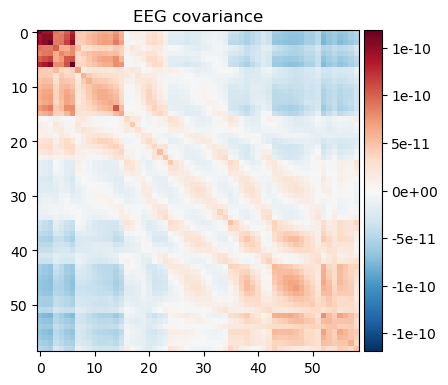

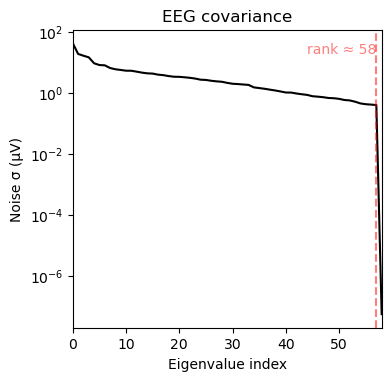

In [ ]:
noise_cov_spect_full.plot(info=eeg_info);

The results are very similar. Note however that subtle differences exist as summing does not take into account the overlap between individual wavelets.
To improve precision, one needs to make sure that the spacing and width of the wavelets covers the frequency range without overlap, otherwise some weighted average is needed to remove the overlap.
To achieve results below, we made the spacing 4 times the band width.

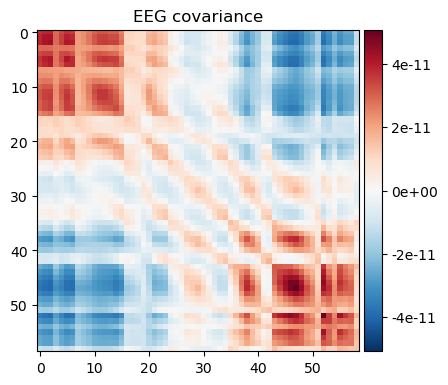

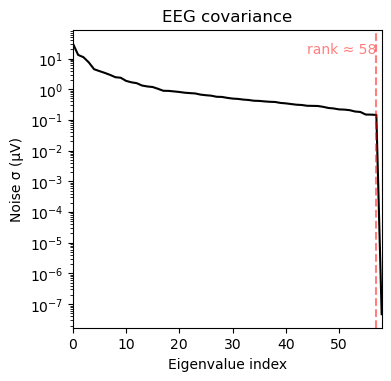

In [ ]:
noise_cov_spect_alpha.plot(info=eeg_info);

This is again very close to the band-pass filtered version. We have seen in the EEG power tutorial, that the peak power was observed over 8Hz. One advantage of the Wavelet approach is that we can readily inspect more narrow frequency bins. In this case, the difference is not striking though.

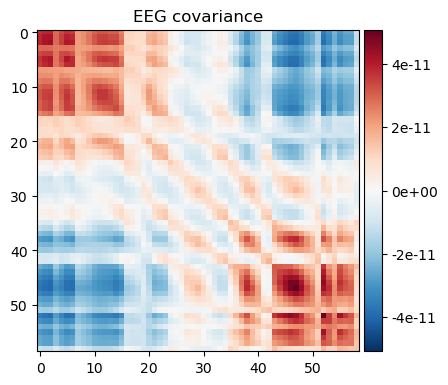

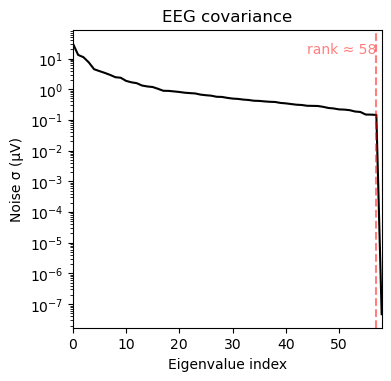

(<Figure size 380x370 with 2 Axes>, <Figure size 380x370 with 1 Axes>)

In [ ]:
noise_cov_spect_alpha2 = mne.cov.Covariance(
    out.cov[..., info.foi == 8][..., 0],
    eeg_info['ch_names'],
    eeg_info['bads'],
    eeg_info['projs'],
    method='morlet-oas',
    nfree=len(raw.times) - 1)

noise_cov_spect_alpha2.plot(eeg_info)

## Investigate equivalence of covariances for spatial whitening

We will see now that the noise covariances obtained are very similar. This is only the case if overlap is controlled and summing is used for combining the covariances.


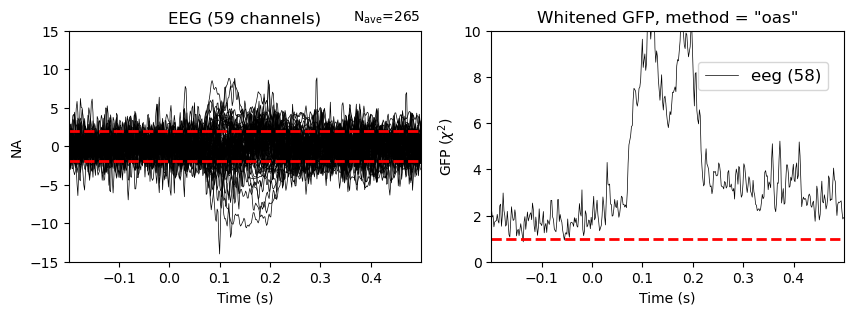

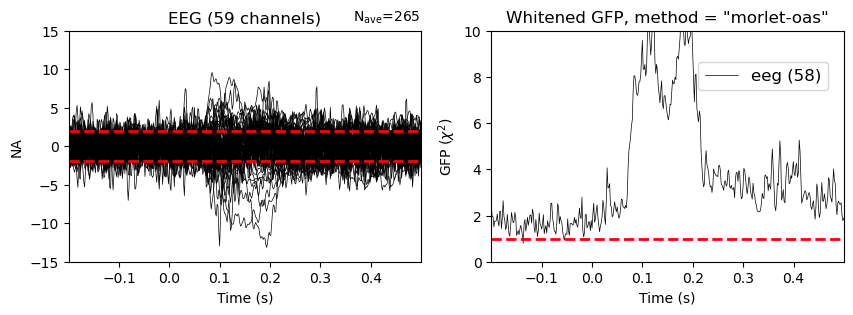

In [ ]:
raw = mne.io.read_raw_fif(raw_fname, preload=True)
raw.pick_types(meg=False, eeg=True, stim=True, eog=True)
events = mne.find_events(raw, stim_channel='STI 014')
event_id = {'auditory/left': 1, 'auditory/right': 2, 'visual/left': 3,
            'visual/right': 4, 'smiley': 5, 'button': 32}
reject = dict(eog=150e-6)
epochs = mne.Epochs(raw, events, event_id=event_id, reject=reject)
evoked = epochs.average()
fig, axes1 = plt.subplots(1, 2, figsize=(10, 3))
axes1[0].set_ylim(-15, 15)
axes1[1].set_ylim(0, 15)

evoked.plot_white(noise_cov=noise_cov, axes=axes1);
fig, axes2 = plt.subplots(1, 2, figsize=(10, 3))
axes2[0].set_ylim(-15, 15)
axes2[1].set_ylim(0, 15)

evoked.plot_white(noise_cov=noise_cov_spect_full, axes=axes2);
